In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from google.colab import files

# Data Loading and Preprocessing

In [4]:
uploaded = files.upload()

Saving marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv to marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv


In [5]:
train_data = pd.read_csv("marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv", sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [6]:
train_data = train_data[['Uniq Id','Product Id','Product Rating','Product Reviews Count','Product Category','Product Brand','Product Name','Product Image Url','Product Description','Product Tags']]
train_data.head()

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,NaN,NaN,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,NaN,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [7]:
train_data.shape

(5000, 10)

In [8]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,2806
Product Reviews Count,1654
Product Category,10
Product Brand,13
Product Name,0
Product Image Url,0
Product Description,1127
Product Tags,0


In [9]:
train_data['Product Rating'].fillna(0, inplace=True)
train_data['Product Reviews Count'].fillna(0, inplace=True)
train_data['Product Category'].fillna('', inplace=True)
train_data['Product Brand'].fillna('', inplace=True)
train_data['Product Description'].fillna('', inplace=True)

In [10]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,0


In [11]:
train_data.duplicated().sum()

0

In [12]:
column_name_mapping = {
    'Uniq Id' : 'ID',
    'Product Id' : 'ProdID',
    'Product Rating' : 'Rating',
    'Product Reviews Count' : 'ReviewCount',
    'Product Category' : 'Category',
    'Product Brand' : 'Brand',
    'Product Name' : 'Name',
    'Product Image Url' : 'ImageURL',
    'Product Description' : 'Description',
    'Product Tags' : 'Tags'
}

train_data.rename(columns=column_name_mapping, inplace=True)

In [13]:
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [14]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [15]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8.000000e+00,8.0,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,4.000000e+00,3.0,0.0,0.0,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,9.900000e+02,3.0,0.0,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


# EDA (Exploratory Data Analysis)

In [16]:
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


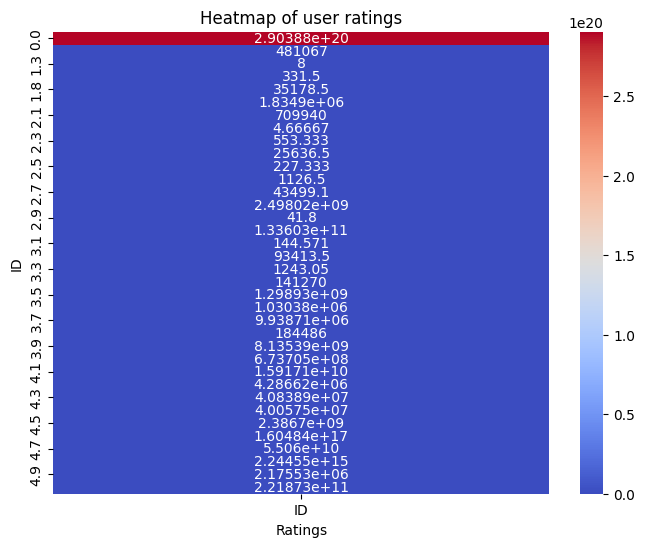

In [17]:
#Pivot the data frame to create a heat map
heatmap_data = train_data.pivot_table('ID','Rating')

#Create the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title("Heatmap of user ratings")
plt.xlabel('Ratings')
plt.ylabel('ID')
plt.show()

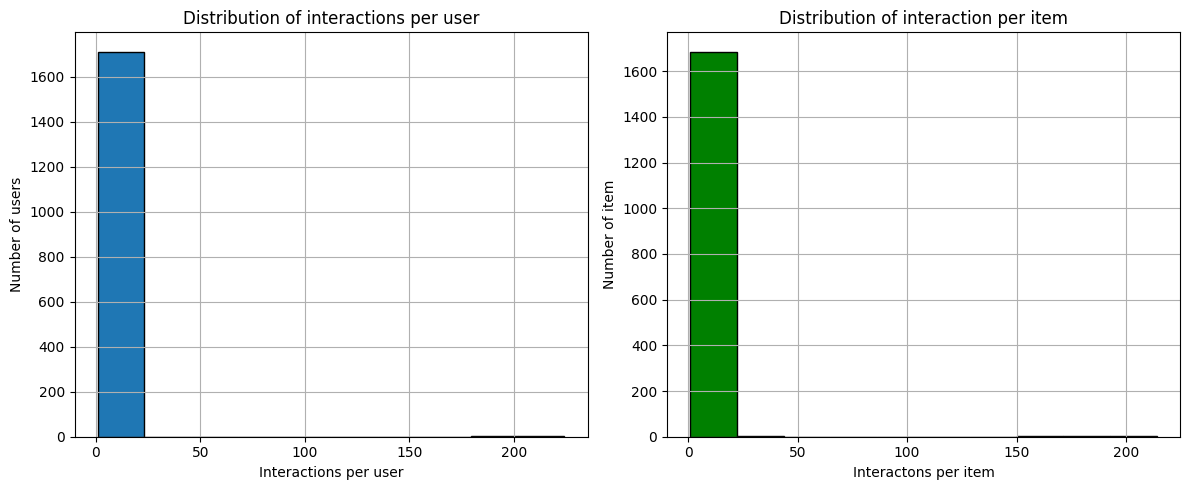

In [18]:
#Distributions of interaction
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel("Interactions per user")
plt.ylabel("Number of users")
plt.title("Distribution of interactions per user")

plt.subplot(1,2,2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k', color='green')
plt.xlabel("Interactons per item")
plt.ylabel("Number of item")
plt.title("Distribution of interaction per item")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular Items')

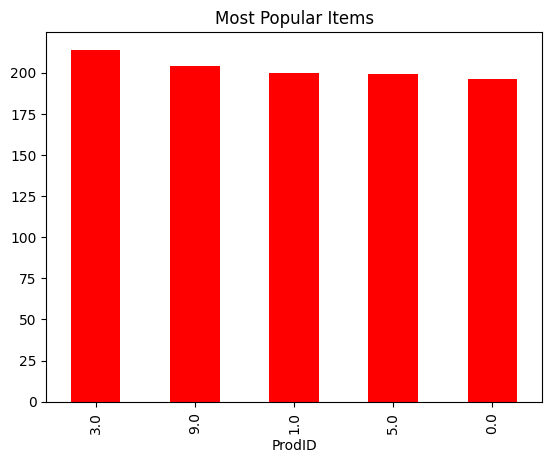

In [19]:
#Most popular items
popular_items = train_data['ProdID'].value_counts().head()
popular_items.plot(kind='bar', color='red')
plt.title("Most Popular Items")

<Axes: xlabel='Rating'>

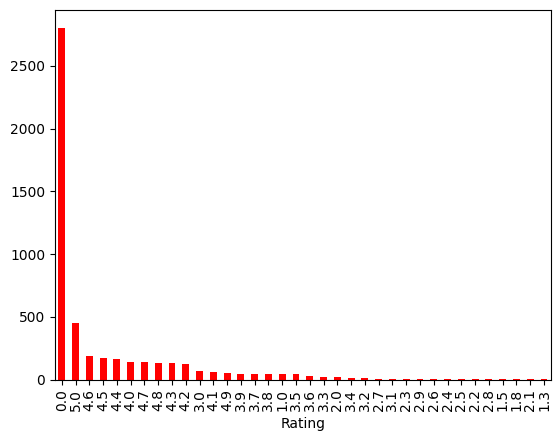

In [20]:
#Most rated counts
train_data['Rating'].value_counts().plot(kind='bar', color='red')

# Data Cleaning and Tags Creation

In [21]:
import spacy
from spacy.lang.en.stop_words import  STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
  doc = nlp(text.lower())
  tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
  return ','.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
  train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [22]:
#Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ','.join(row), axis=1)

In [23]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium,beauty,premium,makeup,premium,nail,pol..."
1,9.500000e+01,76.0,0.0,0.0,"beauty,hair,care,hair,color,auburn,hair,color",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack,3,pack,3,upc,381519000201,beautiful,natur...","beauty,hair,care,hair,color,auburn,hair,color,..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty,hair,care,hair,color,permanent,hair,color",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol,nice,n,easy,permanent,color,gives,8,we...","beauty,hair,care,hair,color,permanent,hair,col..."
3,4.000000e+00,3.0,0.0,0.0,"beauty,makeup,lip","kokie,cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling,matte,lip,lovers,indulge,rich,creamy,m...","beauty,makeup,lip,kokie,cosmetics,calling,matt..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal,stock,essentials,personal,care,stock,...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971,gillette,introduced,trac,ii,razor,system,...","seasonal,stock,essentials,personal,care,stock,..."


# Rating Base Recommendation System

In [24]:
average_ratings =  train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [25]:
top_rated_items = average_ratings.sort_values(by='Rating',ascending=False)
rating_based_recomendation_system = top_rated_items.head(10)

In [26]:
rating_based_recomendation_system.loc[:, 'Rating']= rating_based_recomendation_system['Rating'].astype(int)
rating_based_recomendation_system.loc[:, 'ReviewCount'] = rating_based_recomendation_system['ReviewCount'].astype(int)

In [27]:
print("Ratings based REcomendation System: (Trending products)")
rating_based_recomendation_system.loc[:, ['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_based_recomendation_system.loc[:, ['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_based_recomendation_system

Ratings based REcomendation System: (Trending products)


,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4.0,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5.0
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2.0,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5.0
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2.0,"gold,bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5.0
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24.0,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5.0
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2.0,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5.0
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1.0,"red,devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5.0
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1.0,"air,wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5.0
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4.0,"bain,de,terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5.0
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12.0,"long,aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5.0
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1.0,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5.0


# Content Base Recommendation Sytem

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_metrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_metrix_content,tfidf_metrix_content)

In [30]:
cosine_similarities_content

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

In [31]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [32]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [33]:
similar_items = sorted(similar_items , key = lambda x:x[1], reverse = True)
top_similar_items = similar_items[1:10]


recommended_items_indics = [x[0] for x in top_similar_items]

In [34]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


In [35]:
#Full function for content based recommendation
def content_based_recommendations(train_data,item_name,top_n=10):
  if item_name not in train_data['Name'].values:
    print(f"Item '{item_name}' not found in the training data.")
    return pd.DataFrame()

  tfidf_vectorizer = TfidfVectorizer(stop_words='english')

  tfidf_metrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

  cosine_similarities_content = cosine_similarity(tfidf_metrix_content,tfidf_metrix_content)

  item_index = train_data[train_data['Name']==item_name].index[0]

  similar_items = list(enumerate(cosine_similarities_content[item_index]))

  similar_items = sorted(similar_items , key = lambda x:x[1], reverse = True)

  top_similar_items = similar_items[1:top_n]

  recommended_items_indics = [x[0] for x in top_similar_items]

  recommended_items_details = train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

  return recommended_items_details


In [36]:
item_name = 'Nice n Easy Permanent Color, 111 Natural Medium Auburn 1 ea (Pack of 3)'
test1 = content_based_recommendations(train_data,item_name,top_n=8)
test1

,Name,ReviewCount,Brand
4504,"Nice n Easy Permanent Color, Natural Light Gol...",0.0,easy
4688,Natural Instincts Non-Permanent Color - 5A (Me...,1.0,"natural,instincts"
4728,Nice N Easy 112a Reddish Brown Hair Clr,314.0,"nice,n,easy"
3283,Clairol Nice n Easy Permanent Hair Color Creme...,28392.0,clairol
3416,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol
4664,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol
3901,Clairol Nice n Easy Permanent Hair Color Creme...,28382.0,clairol


# Collaborative Filtering

In [37]:
user_item_matrix = train_data.pivot_table(index = 'ID', columns = 'ProdID', values = 'Rating', aggfunc = 'mean').fillna(0).astype(int)

In [38]:
user_item_matrix

ProdID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00,...,1.007940e+42,1.007940e+42,1.008730e+42,1.030521e+42,1.030521e+42,1.030521e+42,1.076430e+42,3.002240e+42,5.002240e+42,5.005509e+42
ID,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,2,1,2,1,1,0,2,1,1,1,...,0,0,0,0,0,0,5,0,0,0
1.000000e+00,1,0,2,2,0,2,3,2,0,2,...,0,4,0,0,5,0,0,0,0,0
2.000000e+00,1,1,3,1,2,1,0,2,1,1,...,0,3,0,0,0,0,0,0,0,4
3.000000e+00,1,1,1,2,0,3,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4.000000e+00,3,0,2,1,1,1,0,2,1,3,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.967409e+13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.094514e+14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.007694e+17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
user_similarity = cosine_similarity(user_item_matrix)

In [40]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [41]:
user_similarities = user_similarity[target_user_index]
similar_user_indices = user_similarities.argsort()[::-1][1:]

In [42]:
recommend_items = []
for user_index in similar_user_indices:
  rated_by_similar_user = user_item_matrix.iloc[user_index]
  not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] ==0)

  recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating' ]]

In [43]:
recommended_items_details

,Name,ReviewCount,Brand,ImageURL,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design,essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0
...,...,...,...,...,...
4983,Covidien Simplicity Underpad - 7136CS - 23&quo...,0.0,covidien,https://i5.walmartimages.com/asr/2b5ce91e-7b16...,0.0
4987,2oz - Artizen Breathe Blend Essential Oil (100...,1.0,artizen,https://i5.walmartimages.com/asr/99ddd317-013e...,5.0
4990,2 Pack - Crest 3D White Brilliance Fluoride An...,43.0,crest,https://i5.walmartimages.com/asr/5758fbaf-5515...,4.7
4996,Garnier Nutrisse Nourishing Hair Color Creme (...,7484.0,garnier,https://i5.walmartimages.com/asr/24d7a837-51f8...,3.9


Function That Recommend Items

In [44]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n = 10):
  #Create the user-item matrix
  user_item_matrix = train_data.pivot_table(index = 'ID', columns = 'ProdID', values = 'Rating', aggfunc = 'mean').fillna(0).astype(int)

  #Calculate the user similarity matrix
  user_similarity = cosine_similarity(user_item_matrix)

  #Find the index of the target user in the matrix
  target_user_index = user_item_matrix.index.get_loc(target_user_id)

  #Get the similarity scores for the target user
  user_similarities = user_similarity[target_user_index]

  #sort the users by similarity in descending order(excluding the target user)
  similar_user_indices = user_similarities.argsort()[::-1][1:]

  #Generate recommendations based on similar users
  recommend_items = []

  for user_index in similar_user_indices:
    #Get items rated by the similar user but not by the target user
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] ==0)

    #Extract the item IDs of recommended items
    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

  #Get the details of recommended items
  recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating' ]]

  return recommended_items_details

# Example usage
target_user_id = 10
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec.head(5)



Top 5 recommendations for User 10:


,Name,ReviewCount,Brand,ImageURL,Rating
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",0.0,opi,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,0.0
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
4,"Gillette TRAC II Plus Razor Blade Refills, Fit...",131.0,gillette,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,0.0
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
24,Hempz Milk & Honey Herbal Body Moisturizer 2.2...,7.0,hempz,https://i5.walmartimages.com/asr/83e236e5-392c...,0.0


# Hybrid Recommendation

In [45]:
def hybrid_recommendation_systems(train_data, target_user_id, item_name, top_n=10):
  content_based_rec = content_based_recommendations(train_data, item_name, top_n)
  collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id, top_n)
  hybrid_recommendations = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

  return hybrid_recommendations.head(10)

In [57]:
train_data.head()

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium,beauty,premium,makeup,premium,nail,pol..."
1,9.500000e+01,76.0,0.0,0.0,"beauty,hair,care,hair,color,auburn,hair,color",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack,3,pack,3,upc,381519000201,beautiful,natur...","beauty,hair,care,hair,color,auburn,hair,color,..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty,hair,care,hair,color,permanent,hair,color",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol,nice,n,easy,permanent,color,gives,8,we...","beauty,hair,care,hair,color,permanent,hair,col..."
3,4.000000e+00,3.0,0.0,0.0,"beauty,makeup,lip","kokie,cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling,matte,lip,lovers,indulge,rich,creamy,m...","beauty,makeup,lip,kokie,cosmetics,calling,matt..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal,stock,essentials,personal,care,stock,...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971,gillette,introduced,trac,ii,razor,system,...","seasonal,stock,essentials,personal,care,stock,..."


In [56]:
target_user_id = 4
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'
hybrid_rec = hybrid_recommendation_systems(train_data, target_user_id, item_name, top_n=10)
print(f"Top 10 recommendations for user {target_user_id} and item {item_name}: ")
hybrid_rec

Top 10 recommendations for user 4 and item Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum: 


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black,radiance",NaN,NaN
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black,radiance",NaN,NaN
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie,cosmetics",NaN,NaN
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie,cosmetics",NaN,NaN
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,NaN,NaN
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",NaN,NaN
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",NaN,NaN
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,NaN,NaN
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,NaN,NaN
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
